## Pretraitement des donnees

1. suppression des colonnes inutiles
2. gestion des vals manquantes
3. normalisation des donnees

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Charger le dataset
df = pd.read_csv("DatasetExos.csv", sep=';')  # Remplace avec ton chemin d'accès

# Afficher un aperçu initial des données
print("Aperçu des données brutes :")
print(df.head())

# Étape 1 : Corriger les colonnes contenant des valeurs mal formatées
# Remplacer les points multiples ou caractères non numériques par des valeurs manquantes (NaN)
for col in ["Gyro_x", "Gyro_y", "Gyro_z", "Acc_x", "Acc_y", "Acc_z","Set"]:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^\d.-]', '', regex=True), errors='coerce')

# Étape 2 : Supprimer les colonnes inutiles
df_clean = df.drop(columns=["ep (ms)", "ID", "Label"])

# Étape 3 : Gérer les valeurs manquantes (supprimer ou imputer)
df_clean = df_clean.dropna()

# Explicitly convert the 'Set' column to categorical type
#df_clean['Set'] = df_clean['Set'].astype('category')

df_clean['Category'] = df_clean['Category'].astype(str)


# Étape 3 : Séparer les colonnes numériques et catégoriques
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
categorical_columns = df_clean.select_dtypes(exclude=[np.number]).columns

# Normalisation des colonnes numériques uniquement
scaler = StandardScaler()
df_clean[numeric_columns] = scaler.fit_transform(df_clean[numeric_columns])

# Afficher les données après nettoyage et normalisation
print("\nDonnées après nettoyage et normalisation :")
print(df_clean.head())

# Vérification des colonnes catégoriques
print("\nColonnes catégoriques conservées :")

print(df_clean[categorical_columns].head())



Aperçu des données brutes :
                   ep (ms)                   Acc_x               Acc_y  \
0  2019-01-11 15:08:05.200                  0.0135               0.977   
1  2019-01-11 15:08:05.400  -0.0014999999999999996  0.9704999999999999   
2  2019-01-11 15:08:05.600   0.0013333333333333333  0.9716666666666667   
3  2019-01-11 15:08:05.800                  -0.024               0.957   
4  2019-01-11 15:08:06.000   -0.027999999999999997  0.9576666666666666   

                  Acc_z          Gyro_x               Gyro_y  \
0                -0.071  -2.094.366.723          257.720.316   
1  -0.07949999999999999         -16.826              -0.8904   
2  -0.06433333333333334     526.942.212  -0.2559999999999999   
3               -0.0735           8.061              -45.244   
4                -0.115           2.439              -15.486   

               Gyro_z ID  Label Category   Set  
0  0.9388000000000002  B  bench    heavy  30.0  
1              21.708  B  bench    heavy  30

In [2]:
print(len(df_clean))

4016


## 1 Calcul de la distance ( Manhatan et Hamming )

##### condition pour les colonnes categoriques et numeriques

In [3]:
def calculate_distance(instance1, instance2):
    distance = 0.0
    for col in instance1.index:
        if isinstance(instance1[col], str) and isinstance(instance2[col], str):
            # Si les deux colonnes sont des chaînes de caractères (catégoriques)
            if instance1[col] != instance2[col]:
                distance += 1  # Distance de Hamming
        elif pd.api.types.is_numeric_dtype(type(instance1[col])) and pd.api.types.is_numeric_dtype(type(instance2[col])):
            # Si les deux colonnes sont numériques
            distance += abs(instance1[col] - instance2[col])  # Distance de Manhattan
        else:
            # Types incohérents ou inattendus
            raise TypeError(f"Incompatibilité de types pour {col}: {type(instance1[col])} et {type(instance2[col])}")
    return distance



## Calcul de la centroide ( gestion des colonnes numeriques et categoriques)

In [4]:
def calculate_centroid(cluster_points):
    # Séparer les colonnes numériques et catégoriques
    numeric_columns = cluster_points.select_dtypes(include=[np.number])
    categorical_columns = cluster_points.select_dtypes(exclude=[np.number])

    # Calcul du centroïde pour les colonnes numériques (moyenne)
    numeric_centroid = numeric_columns.mean()

    # Calcul du mode pour les colonnes catégoriques (le mode est la catégorie la plus fréquente)
    if not categorical_columns.empty:
        categorical_centroid = categorical_columns.mode().iloc[0]  # Mode par colonne
    else:
        categorical_centroid = pd.Series(dtype='object')
    
    # Combiner les deux
    if categorical_centroid.empty:
        return numeric_centroid
    else:
        return pd.concat([numeric_centroid, categorical_centroid])


## Trouver le cluster le plus proche

In [5]:
def find_closest_cluster(instance, centroids):
    min_distance = float('inf')
    closest_cluster = None
    for cluster_id, centroid in enumerate(centroids):
        dist = calculate_distance(instance, centroid)
        if dist < min_distance:
            min_distance = dist
            closest_cluster = cluster_id
    return closest_cluster


## Implementation de l'algorithme K_means

In [6]:
def k_means(df, k, max_iterations=100):
    # Initialisation aléatoire des centroïdes
    centroids = [df.sample().iloc[0] for _ in range(k)]

    for iteration in range(max_iterations):
        print(f"Iteration {iteration+1}/{max_iterations}")
        clusters = {i: [] for i in range(k)}

        # Assigner chaque point au cluster le plus proche
        for i, instance in df.iterrows():
            closest_cluster = find_closest_cluster(instance, centroids)
            clusters[closest_cluster].append(i)

        # Recalculer les centroïdes
        new_centroids = []
        for cluster_id, indices in clusters.items():
            cluster_points = df.loc[indices]
            if not cluster_points.empty:
                new_centroids.append(calculate_centroid(cluster_points))
            else:
                # Réinitialiser un centroïde si le cluster est vide
                new_centroids.append(df.sample().iloc[0])

        # Vérifier la convergence (si les centroïdes ne changent plus)
        if all(calculate_distance(centroids[i], new_centroids[i]) == 0 for i in range(k)):
            print("Convergence atteinte.")
            break

        centroids = new_centroids

    return clusters, centroids


## Test de l'algorithme avec K=2 K=5 & K=6 VOILA

In [7]:
# Appliquer le k-means sur ton dataset nettoyé
k_values = [2, 5, 6]
for k in k_values:
    print(f"\nTest avec k={k}")
    clusters, centroids = k_means(df_clean, k)
    for cluster_id, points in clusters.items():
        print(f"Cluster {cluster_id}: {len(points)} points")



Test avec k=2
Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Convergence atteinte.
Cluster 0: 2686 points
Cluster 1: 1330 points

Test avec k=5
Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Convergence atteint

## Interpretation

**Distribution des points par cluster**
- k=2 : La division des points en deux clusters (1330 vs. 2686 points) montre une séparation majoritaire dans deux grands groupes.
- k=5 et k=6 : Les clusters deviennent plus granuleux avec des tailles variables, ce qui peut indiquer une meilleure représentation de la diversité des données.

- Par exemple, pour k=5, le cluster 2 est très petit (130 points), tandis que d’autres clusters (comme le 0 avec 1437 points) sont beaucoup plus grands. Cela pourrait refléter des sous-groupes denses ou des cas rares dans les données.
Pour k=6, la granularité augmente encore, avec un petit cluster (cluster 4, 181 points) et des clusters moyens (525, 736 points).

**Convergence des itérations**
- Le nombre d’itérations nécessaires pour atteindre la convergence varie avec la valeur de k. Par exemple, pour k=2, 8 itérations suffisent, mais pour k=6, il en faut 70. Cela reflète la complexité accrue de séparer les données en plus de groupes.

## Visualisations

1. Réduction de dimensions pour la visualisation des clusters

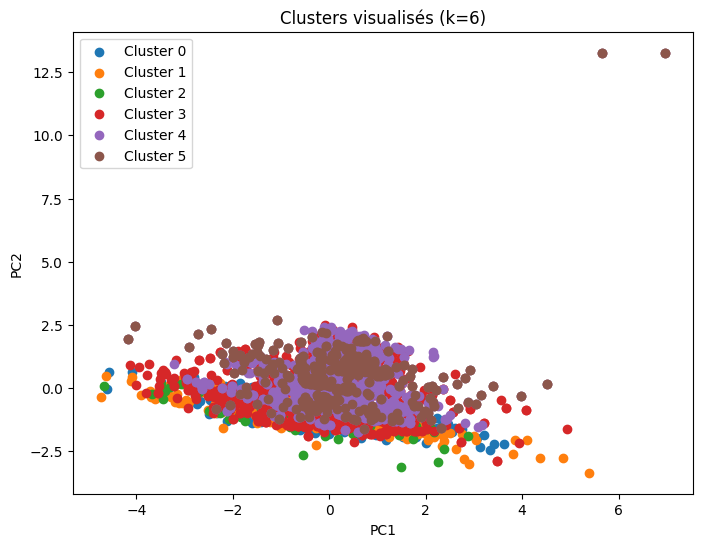

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Réduction à 2 dimensions avec PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_clean.drop(columns=['Category', 'Set']))
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

# Ajouter les labels des clusters
reduced_df['Cluster'] = [cluster for cluster, points in clusters.items() for _ in points]

# Visualisation
plt.figure(figsize=(8, 6))
for cluster_id in range(k):
    cluster_points = reduced_df[reduced_df['Cluster'] == cluster_id]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'], label=f'Cluster {cluster_id}')
plt.title(f'Clusters visualisés (k={k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


Remarque : Le chevauchement des points peut signifier que certaines observations partagent des caractéristiques similaires malgré leur affectation à des clusters différents.

2. Analyse des centroïdes

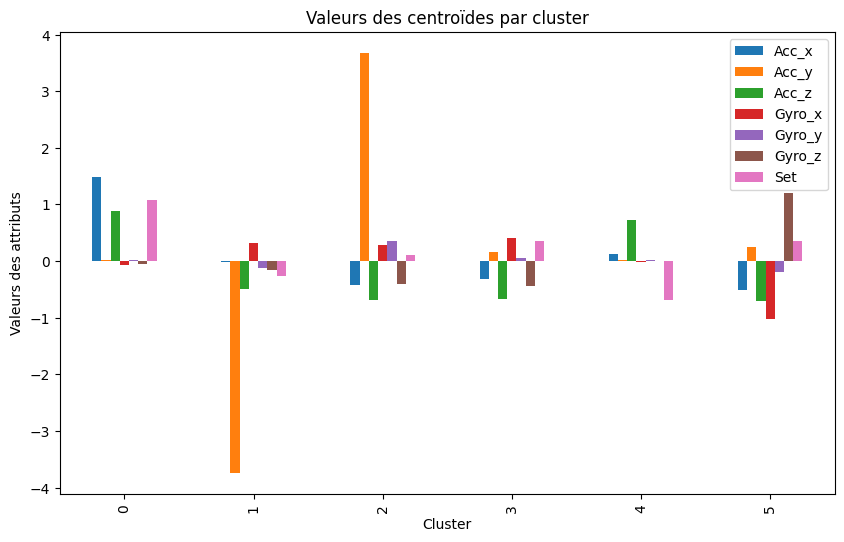

In [9]:
centroids_df = pd.DataFrame(centroids)
centroids_df.plot(kind='bar', figsize=(10, 6))
plt.title('Valeurs des centroïdes par cluster')
plt.xlabel('Cluster')
plt.ylabel('Valeurs des attributs')
plt.show()


remarque : des variations significatives des valeurs des attributs entre les clusters

3. Distribution par cluster

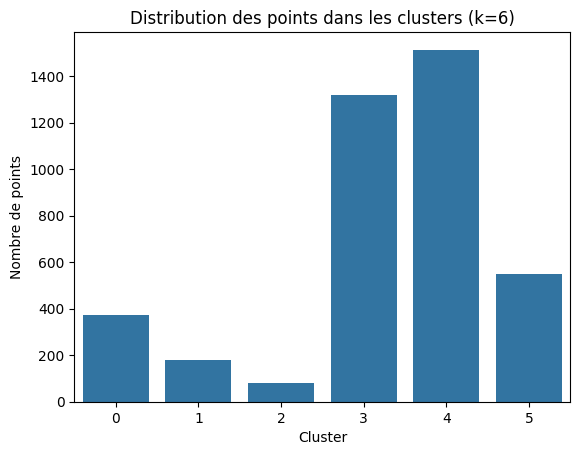

In [10]:
import seaborn as sns

cluster_sizes = [len(points) for points in clusters.values()]
sns.barplot(x=list(range(k)), y=cluster_sizes)
plt.title(f'Distribution des points dans les clusters (k={k})')
plt.xlabel('Cluster')
plt.ylabel('Nombre de points')
plt.show()


Analyse :

- Cluster 2 contient le plus grand nombre de points (~1200 points), ce qui suggère qu'il regroupe une majorité d'observations.
- Cluster 4 est le plus petit avec seulement ~180 points, ce qui pourrait indiquer un comportement particulier ou un outlier group.
Les autres clusters (0, 1, 3, 5) ont une taille intermédiaire, bien répartie.

Interprétation :

- La grande taille de Cluster 2 peut indiquer qu'il capture des mouvements génériques ou des valeurs moyennes pour plusieurs types d'exercices.
- La petite taille de Cluster 4 pourrait correspondre à des exercices rares ou des anomalies dans les données.